In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, MetaData, Table

In [5]:
# Create engine using the `hawaii.sqlite` database file
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

#reflect database
Base = automap_base()
#reflect tables
Base.prepare(engine, reflect=True)

# We can view all of the classes that automap found
Base.classes.keys()   

['measurement', 'station']

In [6]:
 # Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station  

In [7]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [8]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database
current_date = (session.query(Measurement.date)
                     .order_by(Measurement.date.desc())
                     .first())

#extract string from query object
current_date = list(np.ravel(current_date))[0]

#convert date string to datetime object
current_date = dt.datetime.strptime(current_date, '%Y-%m-%d')

#extract year, month, and day as integers
current_yr = int(dt.datetime.strftime(current_date, '%Y'))
current_month = int(dt.datetime.strftime(current_date, '%m'))
current_day = int(dt.datetime.strftime(current_date, '%d'))

#calculate one year before latest date
previous_yr = dt.date(current_yr, current_month, current_day) - dt.timedelta(days=365)


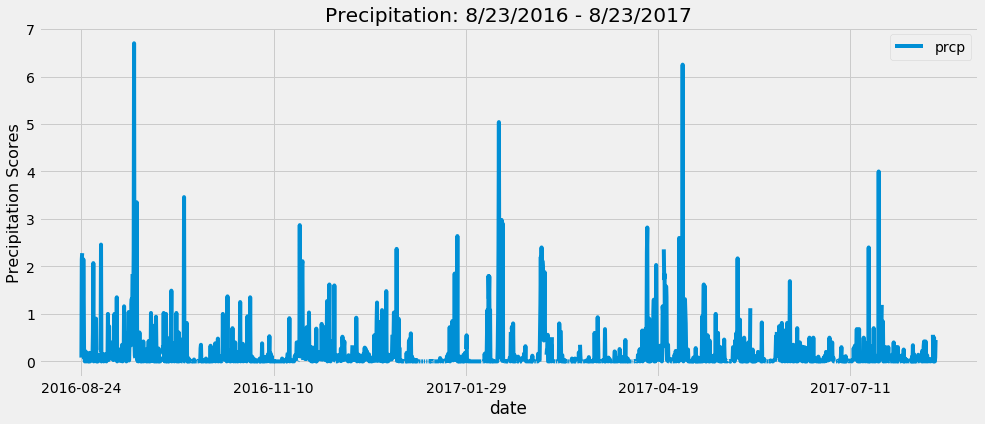

In [81]:
# Perform a query to retrieve the data and precipitation scores
rain_data = (session.query(Measurement.date, Measurement.prcp)
                  .filter(Measurement.date > previous_yr)
                  .order_by(Measurement.date)
                  .all())

# Save the query results as a Pandas DataFrame and set the index to the date column
rain_df = pd.DataFrame(rain_data)
rain_df = rain_df.set_index('date')

# Sort the dataframe by date
rain_df = rain_df.sort_index(ascending=True)

# Use Pandas Plotting with Matplotlib to plot the data
rain_df.plot(title="Precipitation: 8/23/2016 - 8/23/2017",figsize=[15,6])
plt.ylabel("Precipitation Scores", size=16);

In [10]:
# Use Pandas to calcualte the summary statistics for the precipitation data
rain_df.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [11]:
# Design a query to show how many stations are available in this dataset?
station_count = session.query(Station).count()
print(f"{station_count} : Available Stations")

9 : Available Stations


In [12]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
station_count = (session.query(Measurement.station, func.count(Measurement.station))
                        .group_by(Measurement.station)
                        .order_by(func.count(Measurement.station).desc())
                        .all())
station_count

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [13]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

#Assign most active station from station count
most_active = station_count[0][0]

#query station name
name = (session.query(Station.name)
               .filter_by(station = most_active))
name = name[0][0]   
print(f"{most_active} : {name}")

#query highest temp
high_temp = (session.query(Measurement.tobs)
                      .filter(Measurement.station == most_active)
                      .order_by(Measurement.tobs.desc())
                      .first())
high_temp = high_temp[0]
print(f"Hightest Temp. : {high_temp} F")

#query lowest temp
low_temp = (session.query(Measurement.tobs)
                     .filter(Measurement.station == most_active)
                     .order_by(Measurement.tobs.asc())
                     .first())
low_temp = low_temp[0]
print(f"Lowest Temp. : {low_temp} F")

#query average temp
avg_temp = (session.query(func.avg(Measurement.tobs))
                     .filter(Measurement.station == most_active))
avg_temp = '{0:.3}'.format(avg_temp[0][0])
print(f"Average Temp. : {avg_temp} F")


USC00519281 : WAIHEE 837.5, HI US
Hightest Temp. : 85.0 F
Lowest Temp. : 54.0 F
Average Temp. : 71.7 F


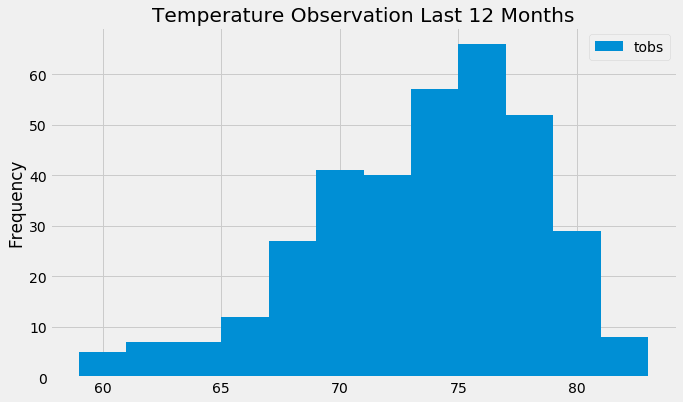

In [72]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

temp_data = (session.query(Measurement.date, Measurement.tobs)
                    .filter(Measurement.date > previous_yr)
                    .filter(Measurement.station == most_active)
                    .order_by(Measurement.date)
                    .all())

#convert query object to data frame
temp_df = pd.DataFrame(temp_data)
temp_df = temp_df.set_index('date')

#sory by dat-e
temp_df = temp_df.sort_index(ascending=True)

#histogram plot with pandas
temp_df.plot(kind='hist', bins=12,title="Temperature Observation Last 12 Months",figsize=[10,6]);


## Bonus Challenge Assignment

In [15]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [16]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [17]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [18]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [19]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [20]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [21]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [22]:
# Plot the daily normals as an area plot with `stacked=False`
